In [26]:
import numpy as np
import pandas as pd

from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

In [27]:
def print_separator(title):
    print("\n" + "=" * 70)
    print(f" {title}")
    print("=" * 70)


In [28]:
class LogisticRegressionL2(BaseEstimator, ClassifierMixin):
    """
    Sıfırdan Logistic Regression (L2 regularization ile),
    sklearn GridSearchCV ile uyumlu.

    Burada **standartlaştırma modelin içinde** yapılıyor:
    - fit sırasında: train verisine göre mean/std hesaplanıyor
    - predict/predict_proba sırasında: gelen X aynı mean/std ile scale ediliyor
    Böylece GridSearchCV her fold için scaler'ı sadece o fold'un train'i ile fit etmiş oluyor.
    """

    def __init__(self, learning_rate=0.01, n_iters=1000, lambda_param=0.1, standardize=True):
        self.learning_rate = learning_rate
        self.n_iters = n_iters
        self.lambda_param = lambda_param
        self.standardize = standardize

        self.weights_ = None
        self.bias_ = None
        self.loss_history_ = []

        # scaling parametreleri
        self.mean_ = None
        self.std_ = None

    def _sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    # ----- Standardization yardımcı fonksiyonları -----
    def _fit_standardizer(self, X):
        self.mean_ = X.mean(axis=0)
        self.std_ = X.std(axis=0)
        self.std_[self.std_ == 0] = 1.0  # sıfıra bölmeyi engelle

    def _transform_standardizer(self, X):
        return (X - self.mean_) / self.std_

    def _preprocess_X(self, X):
        X = np.asarray(X, dtype=float)
        if self.standardize and self.mean_ is not None:
            X = self._transform_standardizer(X)
        return X

    # ----- fit / predict -----
    def fit(self, X, y):
        X = np.asarray(X, dtype=float)
        y = np.asarray(y).ravel()

        # standartlaştırma: sadece train'e göre
        if self.standardize:
            self._fit_standardizer(X)
            X = self._transform_standardizer(X)

        n_samples, n_features = X.shape
        self.weights_ = np.zeros(n_features)
        self.bias_ = 0.0
        self.loss_history_ = []

        lr = self.learning_rate
        lam = self.lambda_param

        for _ in range(self.n_iters):
            linear_model = np.dot(X, self.weights_) + self.bias_
            y_pred = self._sigmoid(linear_model)

            dw = (1 / n_samples) * (np.dot(X.T, (y_pred - y)) + 2 * lam * self.weights_)
            db = (1 / n_samples) * np.sum(y_pred - y)

            self.weights_ -= lr * dw
            self.bias_ -= lr * db

        return self

    def predict_proba(self, X):
        X = self._preprocess_X(X)
        linear_model = np.dot(X, self.weights_) + self.bias_
        y_prob_1 = self._sigmoid(linear_model)
        y_prob_0 = 1 - y_prob_1
        return np.vstack([y_prob_0, y_prob_1]).T

    def predict(self, X):
        proba = self.predict_proba(X)[:, 1]
        return (proba > 0.5).astype(int)

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    roc_curve,
    precision_recall_curve
)

# -----------------------------
# METRİK HESAPLAMA
# -----------------------------
def compute_metrics(y_true, y_pred, y_proba=None):
    metrics = {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1-Score": f1_score(y_true, y_pred),
    }
    if y_proba is not None:
        if y_proba.ndim > 1:
            pos_proba = y_proba[:, 1]
        else:
            pos_proba = y_proba
        metrics["ROC-AUC"] = roc_auc_score(y_true, pos_proba)
    else:
        metrics["ROC-AUC"] = None
    return metrics


def print_metrics_table(metrics, title="Results"):
    print(f"\n{title}:")
    print("-" * 40)
    for k, v in metrics.items():
        if v is None:
            print(f"{k:12s}: None")
        else:
            print(f"{k:12s}: {v:.4f}")


# -----------------------------
# CONFUSION MATRIX HEATMAP
# -----------------------------
def plot_confusion_matrix_heatmap(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(5, 4))
    im = ax.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)

    classes = ["0", "1"]
    ax.set_xticks(np.arange(len(classes)))
    ax.set_yticks(np.arange(len(classes)))
    ax.set_xticklabels(classes)
    ax.set_yticklabels(classes)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    ax.set_title(title)

    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(
                j, i, format(cm[i, j], "d"),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black",
            )

    plt.tight_layout()
    plt.show()


# -----------------------------
# ROC CURVE
# -----------------------------
def plot_roc_curve_model(y_true, y_proba, title="ROC Curve"):
    if y_proba.ndim > 1:
        pos_proba = y_proba[:, 1]
    else:
        pos_proba = y_proba

    fpr, tpr, _ = roc_curve(y_true, pos_proba)
    auc = roc_auc_score(y_true, pos_proba)

    fig, ax = plt.subplots(figsize=(5, 4))
    ax.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
    ax.plot([0, 1], [0, 1], "k--", label="Random")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title(title)
    ax.legend(loc="lower right")
    ax.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


# -----------------------------
# PRECISION–RECALL CURVE
# -----------------------------
def plot_precision_recall_curve_model(y_true, y_proba, title="Precision-Recall Curve"):
    if y_proba.ndim > 1:
        pos_proba = y_proba[:, 1]
    else:
        pos_proba = y_proba

    precision, recall, _ = precision_recall_curve(y_true, pos_proba)

    fig, ax = plt.subplots(figsize=(5, 4))
    ax.plot(recall, precision)
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    ax.set_title(title)
    ax.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


# -----------------------------
# METRİK BAR CHART
# -----------------------------
def plot_metrics_bar(metrics, title="Model Performance"):
    names = [k for k in metrics.keys() if metrics[k] is not None]
    values = [metrics[k] for k in names]

    fig, ax = plt.subplots(figsize=(6, 4))
    bars = ax.bar(names, values)
    ax.set_ylim(0, 1.05)
    ax.set_ylabel("Score")
    ax.set_title(title)
    ax.grid(axis="y", alpha=0.3)

    for bar in bars:
        h = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            h + 0.01,
            f"{h:.3f}",
            ha="center",
            va="bottom",
        )

    plt.tight_layout()
    plt.show()


In [30]:
def run_logreg_experiment(X_train_df, X_test_df, y_train_ser, y_test_ser, dataset_name):
    print_separator(f"DATASET: {dataset_name}")
    print(f"Train size: {len(X_train_df)}")
    print(f"Test size : {len(X_test_df)}")
    print("-" * 50)

    # pandas -> numpy
    X_train = X_train_df.to_numpy(dtype=float)
    X_test = X_test_df.to_numpy(dtype=float)
    y_train = y_train_ser.to_numpy(dtype=int)
    y_test = y_test_ser.to_numpy(dtype=int)

    # ================================
    # 1) CUSTOM MODEL (SCRATCH)
    # ================================
    print("CUSTOM MODEL (GridSearchCV ile) TUNING BAŞLIYOR...")

    custom_param_grid = {
        'learning_rate': [0.1, 0.01, 0.001],
        'n_iters': [1000, 2500, 5000],
        'lambda_param': [0.0, 0.1, 1.0]
    }

    custom_base_model = LogisticRegressionL2(standardize=True)

    grid_search_custom = GridSearchCV(
        estimator=custom_base_model,
        param_grid=custom_param_grid,
        cv=5,
        scoring='accuracy',
        n_jobs=-1
    )

    grid_search_custom.fit(X_train, y_train)

    best_custom_model = grid_search_custom.best_estimator_
    best_custom_params = grid_search_custom.best_params_
    best_custom_val_score = grid_search_custom.best_score_

    y_pred_custom = best_custom_model.predict(X_test)
    y_proba_custom = best_custom_model.predict_proba(X_test)
    best_custom_test_acc = accuracy_score(y_test, y_pred_custom)

    print(f"✅ Custom Model (CV) En İyi Train-CV Skoru: %{best_custom_val_score*100:.2f}")
    print(f"✅ Custom Model En İyi Parametreler: {best_custom_params}")
    print(f"✅ Custom Model Test Accuracy         : %{best_custom_test_acc*100:.2f}")
    print("-" * 50)

    # ================================
    # 1B) CUSTOM MODEL GRAFİKLER + METRİK TABLOSU
    # ================================
    metrics_custom = compute_metrics(y_test, y_pred_custom, y_proba_custom)
    print_metrics_table(metrics_custom, title=f"[{dataset_name}] Custom (Scratch)")

    plot_confusion_matrix_heatmap(
        y_test, y_pred_custom,
        title=f"{dataset_name} - Custom LR Confusion Matrix"
    )
    plot_roc_curve_model(
        y_test, y_proba_custom,
        title=f"{dataset_name} - Custom LR ROC Curve"
    )
    plot_precision_recall_curve_model(
        y_test, y_proba_custom,
        title=f"{dataset_name} - Custom LR PR Curve"
    )
    plot_metrics_bar(
        metrics_custom,
        title=f"{dataset_name} - Custom LR Metrics"
    )

    # ================================
    # 2) SKLEARN MODEL PIPELINE
    # ================================
    print("SKLEARN MODEL TUNING BAŞLIYOR...")

    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression(random_state=42, penalty='l2'))
    ])

    sk_param_grid = {
        'clf__C': [0.01, 0.1, 1, 10, 100],
        'clf__solver': ['liblinear', 'lbfgs'],
        'clf__max_iter': [100, 200]
    }

    grid_search_sk = GridSearchCV(
        estimator=pipe,
        param_grid=sk_param_grid,
        cv=5,
        scoring='accuracy',
        n_jobs=-1
    )

    grid_search_sk.fit(X_train, y_train)

    best_sk_model = grid_search_sk.best_estimator_
    best_sk_params = grid_search_sk.best_params_
    best_sk_val_score = grid_search_sk.best_score_

    y_pred_sk = best_sk_model.predict(X_test)
    y_proba_sk = best_sk_model.predict_proba(X_test)
    best_sk_test_acc = accuracy_score(y_test, y_pred_sk)

    print(f"✅ Sklearn Model (CV) En İyi Train-CV Skoru: %{best_sk_val_score*100:.2f}")
    print(f"✅ Sklearn Model En İyi Parametreler       : {best_sk_params}")
    print(f"✅ Sklearn Model Test Accuracy             : %{best_sk_test_acc*100:.2f}")
    print("-" * 50)

    # ================================
    # 2B) SKLEARN MODEL GRAFİKLER + METRİK TABLOSU
    # ================================
    metrics_sk = compute_metrics(y_test, y_pred_sk, y_proba_sk)
    print_metrics_table(metrics_sk, title=f"[{dataset_name}] Sklearn LR")

    plot_confusion_matrix_heatmap(
        y_test, y_pred_sk,
        title=f"{dataset_name} - Sklearn LR Confusion Matrix"
    )
    plot_roc_curve_model(
        y_test, y_proba_sk,
        title=f"{dataset_name} - Sklearn LR ROC Curve"
    )
    plot_precision_recall_curve_model(
        y_test, y_proba_sk,
        title=f"{dataset_name} - Sklearn LR PR Curve"
    )
    plot_metrics_bar(
        metrics_sk,
        title=f"{dataset_name} - Sklearn LR Metrics"
    )

    # ================================
    # 3) FİNAL KARŞILAŞTIRMA
    # ================================
    print(f"\n{'='*50}")
    print(f"[{dataset_name}] FINAL CUSTOM  TEST ACCURACY : %{best_custom_test_acc*100:.2f}")
    print(f"[{dataset_name}] FINAL SKLEARN TEST ACCURACY : %{best_sk_test_acc*100:.2f}")
    print(f"{'='*50}\n")

    return {
        "custom": {
            "cv_acc": best_custom_val_score,
            "test_acc": best_custom_test_acc,
            "params": best_custom_params,
            "metrics": metrics_custom,
        },
        "sklearn": {
            "cv_acc": best_sk_val_score,
            "test_acc": best_sk_test_acc,
            "params": best_sk_params,
            "metrics": metrics_sk,
        },
    }



 SCRATCH LOGISTIC REGRESSION (L2) - TWO HEART DATASETS

 DATASET 1: preprocessed_heart_disease_uci.csv
Dataset 1 shape: (920, 15)
Target distribution:
1    509
0    411
Name: target, dtype: int64

 DATASET: Preprocessed UCI Heart
Train size: 736
Test size : 184
--------------------------------------------------
CUSTOM MODEL (GridSearchCV ile) TUNING BAŞLIYOR...
✅ Custom Model (CV) En İyi Train-CV Skoru: %82.20
✅ Custom Model En İyi Parametreler: {'lambda_param': 0.0, 'learning_rate': 0.01, 'n_iters': 2500}
✅ Custom Model Test Accuracy         : %83.70
--------------------------------------------------

[Preprocessed UCI Heart] Custom (Scratch):
----------------------------------------
Accuracy    : 0.8370
Precision   : 0.8673
Recall      : 0.8333
F1-Score    : 0.8500
ROC-AUC     : 0.9127


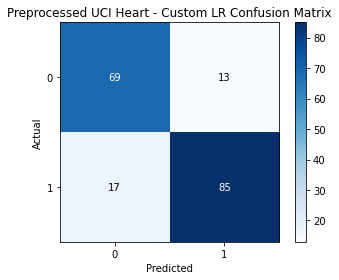

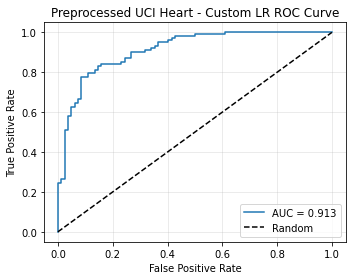

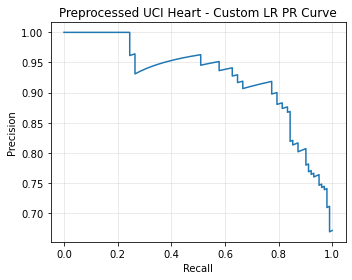

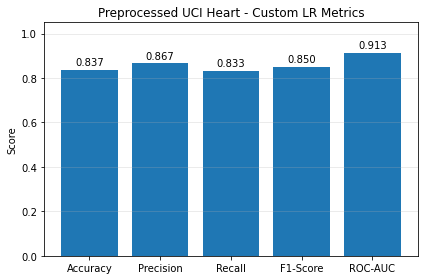

SKLEARN MODEL TUNING BAŞLIYOR...
✅ Sklearn Model (CV) En İyi Train-CV Skoru: %82.47
✅ Sklearn Model En İyi Parametreler       : {'clf__C': 0.01, 'clf__max_iter': 100, 'clf__solver': 'lbfgs'}
✅ Sklearn Model Test Accuracy             : %81.52
--------------------------------------------------

[Preprocessed UCI Heart] Sklearn LR:
----------------------------------------
Accuracy    : 0.8152
Precision   : 0.8269
Recall      : 0.8431
F1-Score    : 0.8350
ROC-AUC     : 0.9083


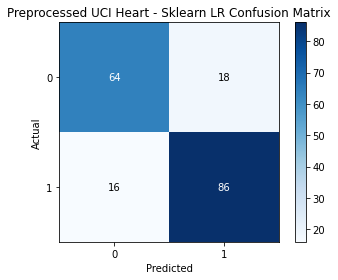

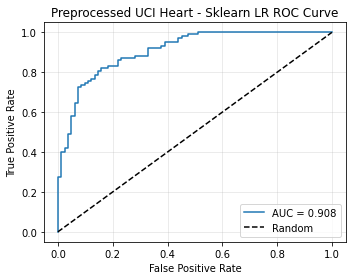

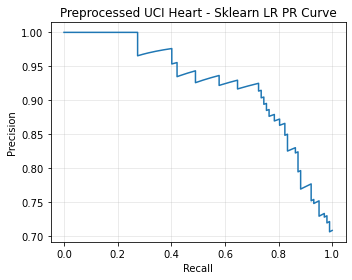

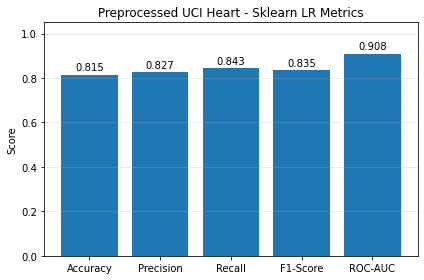


[Preprocessed UCI Heart] FINAL CUSTOM  TEST ACCURACY : %83.70
[Preprocessed UCI Heart] FINAL SKLEARN TEST ACCURACY : %81.52


 DATASET 2: processed_heart.csv
Dataset 2 shape: (918, 16)
Target distribution:
1    508
0    410
Name: HeartDisease, dtype: int64

 DATASET: Processed Heart (Kaggle)
Train size: 734
Test size : 184
--------------------------------------------------
CUSTOM MODEL (GridSearchCV ile) TUNING BAŞLIYOR...
✅ Custom Model (CV) En İyi Train-CV Skoru: %85.82
✅ Custom Model En İyi Parametreler: {'lambda_param': 0.0, 'learning_rate': 0.01, 'n_iters': 1000}
✅ Custom Model Test Accuracy         : %89.13
--------------------------------------------------

[Processed Heart (Kaggle)] Custom (Scratch):
----------------------------------------
Accuracy    : 0.8913
Precision   : 0.8942
Recall      : 0.9118
F1-Score    : 0.9029
ROC-AUC     : 0.9346


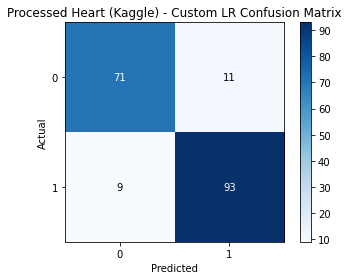

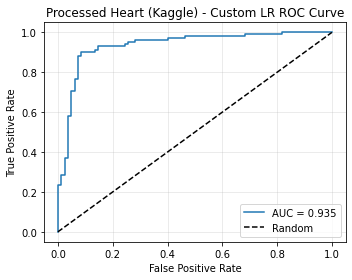

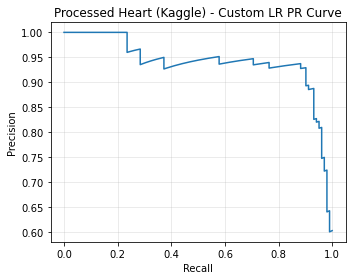

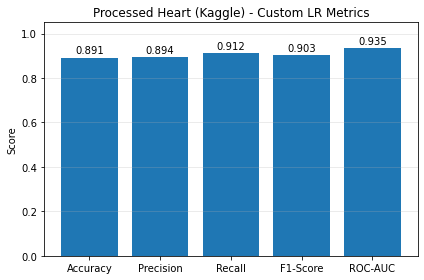

SKLEARN MODEL TUNING BAŞLIYOR...
✅ Sklearn Model (CV) En İyi Train-CV Skoru: %85.96
✅ Sklearn Model En İyi Parametreler       : {'clf__C': 0.01, 'clf__max_iter': 100, 'clf__solver': 'lbfgs'}
✅ Sklearn Model Test Accuracy             : %88.04
--------------------------------------------------

[Processed Heart (Kaggle)] Sklearn LR:
----------------------------------------
Accuracy    : 0.8804
Precision   : 0.8774
Recall      : 0.9118
F1-Score    : 0.8942
ROC-AUC     : 0.9350


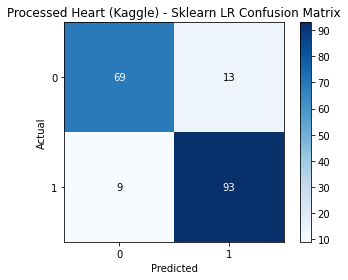

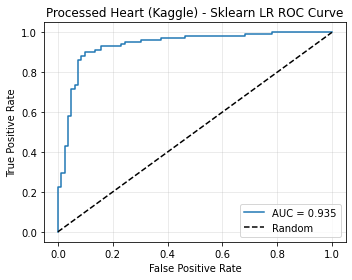

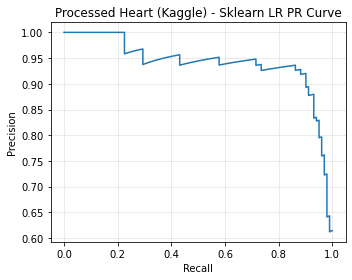

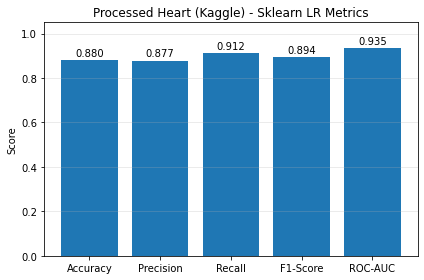


[Processed Heart (Kaggle)] FINAL CUSTOM  TEST ACCURACY : %89.13
[Processed Heart (Kaggle)] FINAL SKLEARN TEST ACCURACY : %88.04


 FINAL SUMMARY (ONLY ACCURACY)

Dataset                        Model          CV Acc   Test Acc
Preprocessed UCI Heart         Custom         0.8220     0.8370
Preprocessed UCI Heart         Sklearn        0.8247     0.8152
--------------------------------------------------------------------------------
Processed Heart (Kaggle)       Custom         0.8582     0.8913
Processed Heart (Kaggle)       Sklearn        0.8596     0.8804
--------------------------------------------------------------------------------


In [31]:
def main():
    print_separator("SCRATCH LOGISTIC REGRESSION (L2) - TWO HEART DATASETS")

    # --------------------------------------------------------
    # 1) preprocessed_heart_disease_uci.csv
    # --------------------------------------------------------
    print_separator("DATASET 1: preprocessed_heart_disease_uci.csv")
    df1 = pd.read_csv("preprocessed_heart_disease_uci.csv")
    X1 = df1.drop("target", axis=1)
    y1 = df1["target"]

    X1_train, X1_test, y1_train, y1_test = train_test_split(
        X1, y1, test_size=0.2, random_state=42, stratify=y1
    )

    print("Dataset 1 shape:", df1.shape)
    print("Target distribution:")
    print(y1.value_counts())

    res1 = run_logreg_experiment(
        X1_train, X1_test, y1_train, y1_test,
        dataset_name="Preprocessed UCI Heart"
    )

    # --------------------------------------------------------
    # 2) processed_heart.csv
    # --------------------------------------------------------
    print_separator("DATASET 2: processed_heart.csv")
    df2 = pd.read_csv("processed_heart.csv")
    X2 = df2.drop("HeartDisease", axis=1)
    y2 = df2["HeartDisease"]

    X2_train, X2_test, y2_train, y2_test = train_test_split(
        X2, y2, test_size=0.2, random_state=42, stratify=y2
    )

    print("Dataset 2 shape:", df2.shape)
    print("Target distribution:")
    print(y2.value_counts())

    res2 = run_logreg_experiment(
        X2_train, X2_test, y2_train, y2_test,
        dataset_name="Processed Heart (Kaggle)"
    )

    # --------------------------------------------------------
    # ÖZET TABLO
    # --------------------------------------------------------
    print_separator("FINAL SUMMARY (ONLY ACCURACY)")
    print("\n" + "=" * 80)
    print(f"{'Dataset':<30} {'Model':<10} {'CV Acc':>10} {'Test Acc':>10}")
    print("=" * 80)

    for name, res in [
        ("Preprocessed UCI Heart", res1),
        ("Processed Heart (Kaggle)", res2),
    ]:
        print(f"{name:<30} {'Custom':<10} {res['custom']['cv_acc']:>10.4f} {res['custom']['test_acc']:>10.4f}")
        print(f"{name:<30} {'Sklearn':<10} {res['sklearn']['cv_acc']:>10.4f} {res['sklearn']['test_acc']:>10.4f}")
        print("-" * 80)


if __name__ == "__main__":
    main()